<a href="https://colab.research.google.com/github/arshambt/MachineLearning2023/blob/main/Bachelor's_Final_Project/Project_GAN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tensorflow example

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

# Create the discriminator
discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }


In [ ]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset.take(50), epochs=22)


11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/22
50/50 [==============================] - 119s 2s/step - d_loss: 0.5358 - g_loss: 0.7459
Epoch 2/22
50/50 [==============================] - 101s 2s/step - d_loss: 0.3327 - g_loss: 1.1281
Epoch 3/22
50/50 [==============================] - 105s 2s/step - d_loss: 0.3100 - g_loss: 1.3848
Epoch 4/22
50/50 [==============================] - 105s 2s/step - d_loss: 0.1240 - g_loss: 2.0308
Epoch 5/22
50/50 [==============================] - 105s 2s/step - d_loss: 0.0457 - g_loss: 3.3686
Epoch 6/22
50/50 [==============================] - 104s 2s/step - d_loss: 0.0301 - g_loss: 4.2623
Epoch 7/22
50/50 [==============================] - 104s 2s/step - d_loss: 0.3015 - g_loss: 2.3485
Epoch 8/22
50/50 [==============================] - 107s 2s/step - d_loss: 0.5703 - g_loss: 1.5432
Epoch 9/22
50/50 [==============================] - 103s 2s/step - d_loss: 0.5403 - g_loss: 1.1650
Epoch 10/22
50/50 [=========================

# Dataset_preprocessing

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive

In [ ]:
!unzip gdrive/MyDrive/Dataset_1st_1.zip

In [ ]:
!unzip gdrive/MyDrive/s-parameters.zip

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1yY9PLMJ_e2tJdAB0VYtCR1dqUyvT289n
!gdown 1bcdQ-04EcyXGVczyHb5oFkFRX487m3lf

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
Downloading...
From: https://drive.google.com/uc?id=1yY9PLMJ_e2tJdAB0VYtCR1dqUyvT289n
To: /content/img_1.png
100% 3.62k/3.62k [00:00<00:00, 11.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/download.py:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = bs4.BeautifulSoup(line, features="html.parser")
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1bcdQ-04EcyXGVczyHb5oFkFRX487m3lf

but Gdown can't. Please check connections and permissions

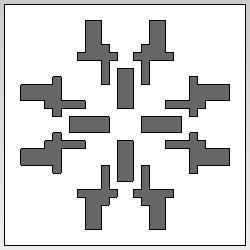

In [ ]:
img = cv2.imread('Dataset_1st/img_1.png')

img2 = img[125:375, 125:375,0].copy()

#cv2.resize(img, (30, 30))
cv2_imshow(img[125:375, 125:375, 0])
img3 = cv2.resize(img2, (30,30))


# 15 * 15

In [ ]:
train_images = []

for i in range (1,501):
  img = cv2.imread(f'Dataset_1st/img_{i}.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  img = img[129:251, 129:251]
  ret, img = cv2.threshold(img, 245, 255, cv2.THRESH_BINARY)
  img = img.astype("float32") / 255.0
  img = cv2.resize(img, (15,15))
  #img = cv2.resize(img, (28,28))
  #img = tf.expand_dims(img, axis=-1)
  train_images.append(img)

print(train_images[2].shape)
print(len(train_images))

(15, 15)
500


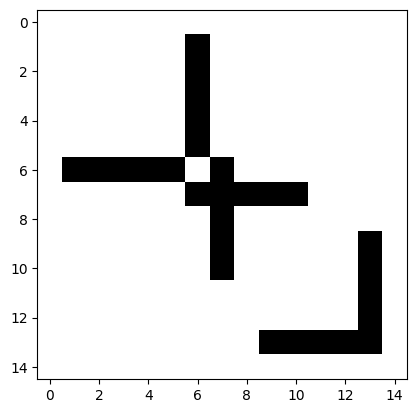

In [ ]:
a = np.zeros((15,15,3))
J=[]

for i in range(250):
  a = np.zeros((15,15,3))
  a[:,:,0] = train_images[2*i]
  a[:,:,1] = train_images[2*i+1]
  a[:,:,2] = a[:,:,0]
  J.append(a)

J[1][:,:,0]
plt.imshow(J[3][:,:,2], cmap='gray')

# PLOT

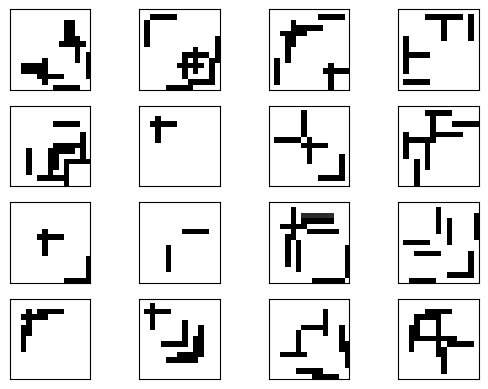

In [ ]:
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(train_images)
dataset = dataset.batch(16)
dataset = dataset.shuffle(50)
j=[]
for element in dataset:
  j.append(element)

print(j[10].shape)

(16, 15, 15)


In [ ]:
for n, real_samples in enumerate(dataset):
  i = real_samples.shape

  print(i[0])

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
4
16
16
16
16
16
16
16
16
16
16
16
16


In [ ]:
import os
import pandas as pd

tr_m = []
tr_ph = []

for i in range(6):
  with open(f's-parameters/test_{i+1}_1.txt', 'r') as f:
    text = f.read()
    tr_m.append(text)
  with open(f's-parameters/test_{i+1}_2.txt', 'r') as f2:
    text2 = f2.read()
    tr_ph.append(text2)


In [ ]:
tr = []

for i in range(6):
  df_m = pd.read_csv(f's-parameters/test_{i+1}_1.txt', sep='\s+', header=None, index_col=False)
  df_ph = pd.read_csv(f's-parameters/test_{i+1}_2.txt', sep='\s+', header=None, index_col=False)
  df = pd.concat([df_m,df_ph], axis=0, ignore_index=True)
  df = df.drop(0, axis=0)
  df = df.drop(1, axis=0)
  df = df.reset_index(drop=True)

  v = pd.to_numeric(df[1], errors = 'coerce')

  tr.append(v)

print(v)


0       -2.660353
1       -2.623166
2       -2.585975
3       -2.548785
4       -2.511600
          ...    
1999   -95.261803
2000   -95.304302
2001   -95.346925
2002   -95.389675
2003   -95.432553
Name: 1, Length: 2004, dtype: float64


In [ ]:
tr_ds = tf.data.Dataset.from_tensor_slices(tr)


l = []
for element in tr_ds:
  print(element)
  l.append(element)

len(l)

tf.Tensor(
[ -0.42029576  -0.44471994  -0.46979037 ... -97.042198   -97.08975
 -97.137515  ], shape=(2004,), dtype=float64)
tf.Tensor(
[ -9.5324251  -9.5687162  -9.6048777 ... -95.418545  -94.987812
 -94.512067 ], shape=(2004,), dtype=float64)
tf.Tensor(
[ -9.0412828  -9.014697   -8.9880174 ... -85.075884  -85.117092
 -85.158301 ], shape=(2004,), dtype=float64)
tf.Tensor([-13.382558 -13.414224 -13.445791 ... -42.416388 -47.994139 -52.83704 ], shape=(2004,), dtype=float64)
tf.Tensor(
[ -4.1590062  -4.1498337  -4.1404861 ... -86.375132  -86.400552
 -86.425939 ], shape=(2004,), dtype=float64)
tf.Tensor(
[ -2.6603532  -2.6231657  -2.585975  ... -95.346925  -95.389675
 -95.432553 ], shape=(2004,), dtype=float64)


6

In [ ]:
df_m = pd.read_csv('/content/Dt_1.txt', sep='\s+', header=None)
df_ph = pd.read_csv('/content/DT_2.txt', sep='\s+', header=None)

df = pd.concat([df_m, df_ph], axis=0, ignore_index=True)

d_tr = df.iloc[:,1]

d_tr = d_tr.astype(float)

tr_t = tf.convert_to_tensor(d_tr)
tr_t

<tf.Tensor: shape=(42,), dtype=float64, numpy=
array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
       107., 114., 121., 135., 142., 149., 156., 163., 170., 177., 184.,
       191., 198., 205., 212., 219., 226., 233., 240., 247.])>

# Model_1: Optuna

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import optuna
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization

# Discriminator model
d_model = Sequential()
d_model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="valid"))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="valid"))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Flatten())
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Dense(1, activation='sigmoid'))


# Create the generator
latent_dim = 128
g_model = Sequential()
g_model.add(Dense(7*7*128, input_dim=128))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())



g_model.add(Reshape((7,7,128)))
g_model.add(Conv2DTranspose(128, kernel_size=(3,3), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))


In [ ]:
import tensorflow as tf
import numpy as np
import optuna
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization

# Create the discriminator
def objective(trial):
  d_model = Sequential()
  #n_layers = trial.suggest_int('n_layers', 1, 5)
  #for i in range(n_layers):
  d_model.add(Conv2D(filters= trial.suggest_categorical('filters', [32,64]),
                     kernel_size= trial.suggest_categorical('kernel_size', [3,5]),
                     strides= trial.suggest_categorical('strides', [1,2]),
                     padding='valid', input_shape=(15,15,1)))
  d_model.add(LeakyReLU(alpha=0.2))
  d_model.add(Conv2D(filters= trial.suggest_categorical('filters', [32,64]),
                     kernel_size= trial.suggest_categorical('kernel_size', [3,5]),
                     strides= trial.suggest_categorical('strides', [1,2]),
                     padding='valid'))
  d_model.add(LeakyReLU(alpha=0.2))

  d_model.add(Flatten())
  d_model.add(Dense(1, activation='sigmoid'))

  return d_model

def objective(trial):
  g_model = Sequential()
  #model.add(Input(shape=(128,)))
  g_model.add(Dense(7*7*128, input_dim=128))
  g_model.add(LeakyReLU(alpha=0.2))
  g_model.add(Reshape((7,7,128)))
  g_model.add(Conv2DTranspose(filters= trial.suggest_categorical('filters', [64,128]),
                     kernel_size= trial.suggest_categorical('kernel_size', [3,5]),
                     strides= trial.suggest_categorical('strides', [1,2]),
                     padding='valid'))
  g_model.add(LeakyReLU(alpha=0.2))
  g_model.add(Conv2DTranspose(filters= trial.suggest_categorical('filters', [64,128]),
                     kernel_size= trial.suggest_categorical('kernel_size', [3,5]),
                     strides= trial.suggest_categorical('strides', [1,2]),
                     padding='valid'))
  g_model.add(LeakyReLU(alpha=0.2))
  g_model.add(Conv2DTranspose(filters= trial.suggest_categorical('filters', [64,128]),
                     kernel_size= trial.suggest_categorical('kernel_size', [3,5]),
                     strides= trial.suggest_categorical('strides', [1,2]),
                     padding='valid'))
  g_model.add(LeakyReLU(alpha=0.2))

  g_model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))

  return g_model


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-25 14:35:38,733] A new study created in memory with name: no-name-42f3b8b1-8d4d-4fec-8ac5-ab06312fd1e9


NameError: name 'objective' is not defined

# Model_best

In [ ]:
from tensorflow.keras.layers import Activation

def thresholded_sigmoid(x, threshold=0.5):
    return tf.sigmoid(x - threshold)

# Create a custom layer with the thresholded sigmoid activation
class ThresholdedSigmoid(Activation):
    def __init__(self, threshold=0.5, **kwargs):
        super(ThresholdedSigmoid, self).__init__(lambda x: thresholded_sigmoid(x, threshold), **kwargs)
        self.threshold = threshold

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization

# Discriminator model
d_model = Sequential()
d_model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="valid", input_shape=(15,15,1)))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="valid"))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Flatten())
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Dense(1, activation='sigmoid'))


# Create the generator
latent_dim = 128
g_model = Sequential()
g_model.add(Dense(7*7*128, input_dim=128))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())



g_model.add(Reshape((7,7,128)))
g_model.add(Conv2DTranspose(128, kernel_size=(3,3), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())

g_model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1), padding='same'))

g_model.add(Conv2D(1, (4,4), activation=ThresholdedSigmoid(threshold=0.5), padding='same'))


# Model Test

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation

# Discriminator model
d_model = Sequential()
d_model.add(Conv2D(64, (4, 4), strides=(2, 2), padding="valid", input_shape=(15,15,1)))
d_model.add(LeakyReLU(alpha=0.2))
#d_model.add(Dropout(0.4))
d_model.add(BatchNormalization())

d_model.add(Conv2D(64, (4, 4), strides=(2, 2), padding="valid"))
d_model.add(LeakyReLU(alpha=0.2))
#d_model.add(Dropout(0.4))
d_model.add(BatchNormalization())



d_model.add(Flatten())
d_model.add(Dropout(0.4))
#d_model.add(BatchNormalization())

d_model.add(Dense(1, activation='sigmoid'))


# Create the generator
latent_dim = 128
g_model = Sequential()
g_model.add(Dense(7*7*128, input_dim=128))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())



g_model.add(Reshape((7,7,128)))
g_model.add(Conv2DTranspose(128, kernel_size=(3,3), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())


g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())

#g_model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1), padding='same'))

#g_model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1), padding='same'))

g_model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))

# Model_2: Youtube

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization


def Discriminator():
  model = Sequential()

  model.add(Conv2D(32, 5, input_shape=(15,15,1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  #model.add(Conv2D(128, 5))
  #model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))

  #model.add(Conv2D(256, 5))
  #model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

def Generator():
  model = Sequential()

  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='valid'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 4, padding='valid'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, padding='valid'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))


  model.add(Conv2D(1, 4, activation='sigmoid', padding='same'))

  return model

# Model_3: Paper

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization


# Discriminator model

d_model = Sequential()
d_model.add(Conv2D(64, kernel_size= (3,3), strides=(1,1), padding='valid', input_shape=(15,15,1)))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(BatchNormalization())

d_model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='valid'))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(BatchNormalization())

d_model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='valid'))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(BatchNormalization())

d_model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='valid'))
d_model.add(LeakyReLU(alpha=0.2))
d_model.add(BatchNormalization())

d_model.add(Flatten())
d_model.add(Dense(1, activation='sigmoid'))


# Generator model

g_model = Sequential()

g_model.add(Dense(7*7*128, input_dim=128))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())

g_model.add(Reshape((7,7,128)))
g_model.add(Conv2DTranspose(256, kernel_size=(3,3), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())

g_model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())

g_model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=(1,1), padding='valid'))
g_model.add(LeakyReLU(alpha=0.2))
g_model.add(BatchNormalization())

g_model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))


# Process

In [ ]:
random_latent_vectors = tf.random.normal(shape=(1, 128))

tr_t = tf.expand_dims(d_tr, axis=-1)
tr_t = tf.reshape(tr_t, (1,tr_t.shape[0]))
tr_t = tf.cast(tr_t, tf.float32)

print(tr_t)
input = tf.concat([tr_t, random_latent_vectors], axis=1)
input
generated_samples = g_model(input)

tf.Tensor(
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0. 100. 107. 114. 121. 135. 142. 149.
  156. 163. 170. 177. 184. 191. 198. 205. 212. 219. 226. 233. 240. 247.]], shape=(1, 42), dtype=float32)


ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 128), found shape=(1, 170)

In [ ]:
d_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 8, 8, 32)          320       
                                                                 
 leaky_re_lu_131 (LeakyReLU  (None, 8, 8, 32)          0         
 )                                                               
                                                                 
 conv2d_70 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 batch_normalization_116 (B  (None, 4, 4, 64)          256       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_132 (LeakyReLU  (None, 4, 4, 64)          0         
 )                                                               
                                                     

In [ ]:
g_model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 12544)             1266944   
                                                                 
 reshape_22 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_69 (Conv2  (None, 15, 15, 128)       295040    
 DTranspose)                                                     
                                                                 
 batch_normalization_122 (B  (None, 15, 15, 128)       512       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_139 (LeakyReLU  (None, 15, 15, 128)       0         
 )                                                               
                                                     

In [ ]:
random_latent_vectors = tf.random.normal((16, 128,1))
generated_samples = g_model(random_latent_vectors, training=False)
generated_samples = generated_samples.numpy()

for z in range(generated_samples.shape[0]):
  for i in range(generated_samples.shape[1]):
    for j in range(generated_samples.shape[2]):
      if generated_samples[z,i,j] >= 0.5:
        generated_samples[z,i,j] = 1
      else:
        generated_samples[z,i,j] = 0

generated_samples = tf.convert_to_tensor(generated_samples)
generated_samples[0]

<tf.Tensor: shape=(15, 15, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]],

       [[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
 

In [ ]:
random_latent_vectors = tf.random.normal((16, 128,1))
generated_samples = g_model(random_latent_vectors, training=False)

threshold = 0.5
generated_samples = tf.where(generated_samples >= threshold, tf.ones_like(generated_samples), tf.zeros_like(generated_samples))
generated_samples = tf.sigmoid(generated_samples, threshold)
generated_samples[0]


<tf.Tensor: shape=(15, 15, 1), dtype=float32, numpy=
array([[[0.7310586],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.7310586],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.5      ],
        [0.7310586],
        [0.7310586],
        [0.7310586]],

       [[0.5      ],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.7310586],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.7310586],
        [0.7310586]],

       [[0.5      ],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.7310586],
        [0.7310586],
        [0.7310586],
        [0.5      ],
        [0.7310586],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.5      ],
        [0.7310586],
        [0.7310586]

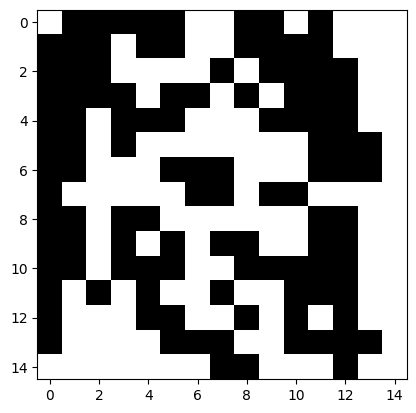

In [ ]:
#random_latent_vectors = tf.random.normal((16, 128,1))
#generated_samples = g_model(random_latent_vectors, training=False)
plt.imshow(generated_samples[0], cmap="gray")


# GAN

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model


g_opt = Adam(learning_rate=0.0003)
d_opt = Adam(learning_rate=0.00003)

loss_function = BinaryCrossentropy()

In [ ]:
tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):

        # Sample random points in the latent space
      threshold = 0.5
      batch_size = tf.shape(real_images)[0]
      random_latent_vectors = tf.random.normal((batch_size, self.latent_dim,1))

        # Decode them to fake images
      generated_samples = self.generator(random_latent_vectors, training=False)


      with tf.GradientTape() as d_tape:

        # Combine them with real images
        combined_images = tf.concat([generated_samples, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))
        noise_real = -0.15*tf.random.uniform((batch_size,1))
        noise_fake = 0.15*tf.random.uniform((batch_size,1))

        labels += tf.concat([noise_fake, noise_real], axis=0)

        # Train the discriminator
        #with tf.GradientTape() as tape:
        predictions = self.discriminator(combined_images, training=True)
        d_loss = self.loss_fn(labels, predictions)
      grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
      self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

      with tf.GradientTape() as g_tape:

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal((batch_size, self.latent_dim,1))
        generated_samples = self.generator(random_latent_vectors, training=True)


        ## THRESHOLD FOR GENERATOR'S OUTPUT ##
      #generated_samples = tf.cast(tf.math.greater_equal(generated_samples, threshold), dtype=tf.float32)

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        #with tf.GradientTape() as tape:
        predictions = self.discriminator(generated_samples, training= False)
        g_loss = self.loss_fn(misleading_labels, predictions)
      grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        # Update metrics and return their value.
      self.d_loss_tracker.update_state(d_loss)
      self.g_loss_tracker.update_state(g_loss)
      return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }


'\n        # Update metrics and return their value.\n      self.d_loss_tracker.update_state(d_loss)\n      self.g_loss_tracker.update_state(g_loss)\n      return {\n            "d_loss": self.d_loss_tracker.result(),\n            "g_loss": self.g_loss_tracker.result(),\n        }\n'

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):

        # Sample random points in the latent space
      threshold = 0.5
      batch_size = tf.shape(real_images)[0]
      random_latent_vectors = tf.random.normal((batch_size, self.latent_dim,1))

        # Decode them to fake images
      generated_samples = self.generator(random_latent_vectors, training=False)
      generated_samples = tf.where(generated_samples >= threshold, tf.ones_like(generated_samples), tf.zeros_like(generated_samples))

      with tf.GradientTape() as d_tape:

        # Combine them with real images
        combined_images = tf.concat([generated_samples, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))
        noise_real = -0.15*tf.random.uniform((batch_size,1))
        noise_fake = 0.15*tf.random.uniform((batch_size,1))

        labels += tf.concat([noise_fake, noise_real], axis=0)

        # Train the discriminator
        #with tf.GradientTape() as tape:
        predictions = self.discriminator(combined_images, training=True)
        d_loss = self.loss_fn(labels, predictions)
      grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
      self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

      with tf.GradientTape() as g_tape:

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal((batch_size, self.latent_dim,1))
        generated_samples = self.generator(random_latent_vectors, training=True)


        ## THRESHOLD FOR GENERATOR'S OUTPUT ##
        #generated_samples = tf.where(generated_samples >= threshold, tf.ones_like(generated_samples), tf.zeros_like(generated_samples))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        #with tf.GradientTape() as tape:
        predictions = self.discriminator(generated_samples, training= False)
        g_loss = self.loss_fn(misleading_labels, predictions)
      grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        # Update metrics and return their value.
      self.d_loss_tracker.update_state(d_loss)
      self.g_loss_tracker.update_state(g_loss)
      return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [ ]:
with tf.GradientTape() as tape:
  random_latent_vectors = tf.random.normal((16, 128,1))
  generated_samples = g_model(random_latent_vectors, training=False)

        ## THRESHOLD FOR GENERATOR'S OUTPUT ##
  #generated_samples = tf.where(generated_samples >= threshold, tf.ones_like(generated_samples), tf.zeros_like(generated_samples))

  misleading_labels = tf.zeros((16, 1))

  predictions = d_model(generated_samples, training= False)

  g_loss = loss_function(misleading_labels, predictions)
grads = tape.gradient(g_loss, g_model.trainable_variables)
g_opt.apply_gradients(zip(grads, g_model.trainable_variables))

print(g_loss)

SyntaxError: invalid syntax (<ipython-input-77-718850b9fc8d>, line 2)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


class ModelMonitor(Callback):
  def __init__(self, num_img=2, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(1):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('GAN_img', f'generated_image_{epoch}_{i}.png'))

In [ ]:
gan = GAN(d_model, g_model, latent_dim=128)

gan.compile(
    d_optimizer = d_opt,
    g_optimizer = g_opt,
    loss_fn = loss_function,
    )

gan.fit(dataset, epochs = 300)

Epoch 1/300
32/32 [==============================] - 4s 33ms/step - d_loss: 0.6977 - g_loss: 0.6887
Epoch 2/300
32/32 [==============================] - 1s 30ms/step - d_loss: 0.7013 - g_loss: 0.6845
Epoch 3/300
32/32 [==============================] - 1s 29ms/step - d_loss: 0.6954 - g_loss: 0.6859
Epoch 4/300
32/32 [==============================] - 1s 33ms/step - d_loss: 0.6997 - g_loss: 0.6882
Epoch 5/300
32/32 [==============================] - 1s 26ms/step - d_loss: 0.6909 - g_loss: 0.6931
Epoch 6/300
32/32 [==============================] - 1s 25ms/step - d_loss: 0.7005 - g_loss: 0.6912
Epoch 7/300
32/32 [==============================] - 1s 29ms/step - d_loss: 0.7133 - g_loss: 0.6723
Epoch 8/300
32/32 [==============================] - 1s 25ms/step - d_loss: 0.7059 - g_loss: 0.6761
Epoch 9/300
32/32 [==============================] - 1s 25ms/step - d_loss: 0.7036 - g_loss: 0.6829
Epoch 10/300
32/32 [==============================] - 1s 25ms/step - d_loss: 0.6976 - g_loss: 0.6908

In [ ]:
batch_size=8
random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
generated_images = g_model(random_latent_vectors)

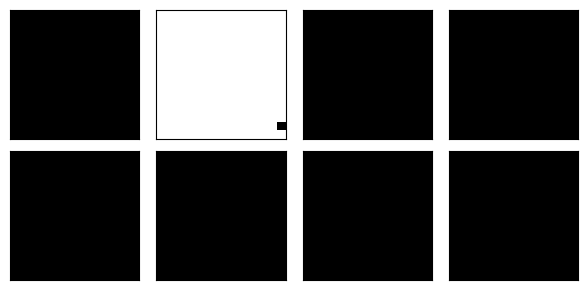

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

batch_size=8
random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
generated_images = g_model(random_latent_vectors)
#generated_images = tf.where(generated_images >= 0.5, tf.ones_like(generated_images), tf.zeros_like(generated_images))
# Assuming you have a list of 8 generated images named `generated_images`
num_samples = len(generated_images)

# Create subplot grid
num_rows = 2
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 3))

# Display generated images
for i, ax in enumerate(axes.flatten()):
    if i < num_samples:
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.build(input_shape=(16, 128,1))

model.load_weights(path)



ValueError: Layer count mismatch when loading weights from file. Model expected 0 layers, found 2 saved layers.

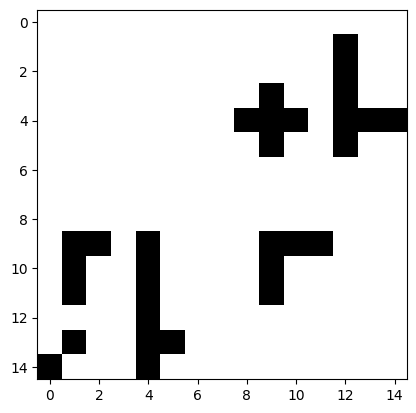

In [ ]:
batch_size=8
random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
generated_images = g_model(random_latent_vectors)
generated_images = tf.where(generated_images >= 0.5, tf.ones_like(generated_images), tf.zeros_like(generated_images))

# Assuming you have a list of 8 generated images named `generated_images`
num_samples = len(generated_images)

# Create subplot grid
plt.imshow(generated_images[0], cmap='gray')

In [ ]:
generated_images[0][14]

<tf.Tensor: shape=(15, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

# 2 Channels

In [ ]:
train_images = []

for i in range (1,501):
  img = cv2.imread(f'Dataset_1st/img_{i}.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  img = img[129:251, 129:251]
  ret, img = cv2.threshold(img, 245, 255, cv2.THRESH_BINARY)
  img = img.astype("float32") / 255.0
  img = cv2.resize(img, (15,15))
  #img = cv2.resize(img, (28,28))
  #img = tf.expand_dims(img, axis=-1)
  train_images.append(img)

print(train_images[2].shape)
print(len(train_images))

(15, 15)
500


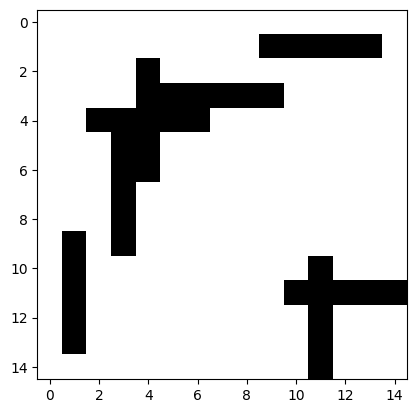

In [ ]:
a = np.zeros((15,15,3))
J=[]

for i in range(250):
  a = np.zeros((15,15,3))
  a[:,:,0] = train_images[2*i]
  a[:,:,1] = train_images[2*i+1]
  a[:,:,2] = a[:,:,0]
  J.append(a)

J[1][:,:,0]
plt.imshow(J[1][:,:,2], cmap='gray')

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(J)
ds = ds.batch(16)
ds = ds.shuffle(50)
j=[]
for element in ds:
  j.append(element)

print(j[10].shape)

(16, 15, 15, 3)


In [ ]:
# Discriminator model
d_model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
d_model.add(Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=(15,15,1),
               padding='same'))

    # Leaky ReLU activation
d_model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
d_model.add(Conv2D(64,
               kernel_size=3,
               strides=2,

               padding='same'))

    # Batch normalization
d_model.add(BatchNormalization())

    # Leaky ReLU activation
d_model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
d_model.add(Conv2D(128,
               kernel_size=3,
               strides=2,

               padding='same'))

    # Batch normalization
d_model.add(BatchNormalization())

    # Leaky ReLU activation
d_model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
d_model.add(Flatten())
d_model.add(Dense(1, activation='sigmoid'))


# Create the generator
latent_dim = 128
g_model = Sequential()

  # Reshape input into 7x7x256 tensor via a fully connected layer
g_model.add(Dense(256 * 7 * 7, input_dim=latent_dim))
g_model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
g_model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='valid'))

    # Batch normalization
g_model.add(BatchNormalization())

    # Leaky ReLU activation
g_model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
g_model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
g_model.add(BatchNormalization())

    # Leaky ReLU activation
g_model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
g_model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same'))

    # Output layer with tanh activation
g_model.add(Activation('tanh'))
